In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import os, glob
import torch

from models.main import build_network
from preprocess import get_data

In [2]:
class Args:
    model='classvdd'
    r='./experiments'
    in_dim=152
    data_pth='../data'
    batch_size=128
    outlier='AGN'
    hierClass='Stochastic'
    fold=1

args = Args()
if args.outlier!='none':
    job_name = '{}_{}_{}_fold{}'.format(args.model, args.hierClass, args.outlier, args.fold)
else:
    job_name = '{}_{}_lr{}_ld{}_fold{}'.format(args.model, args.hierClass, args.lr, 
                                               args.z_dim, args.fold)
args.directory = os.path.join(args.r, job_name)
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Learning curves

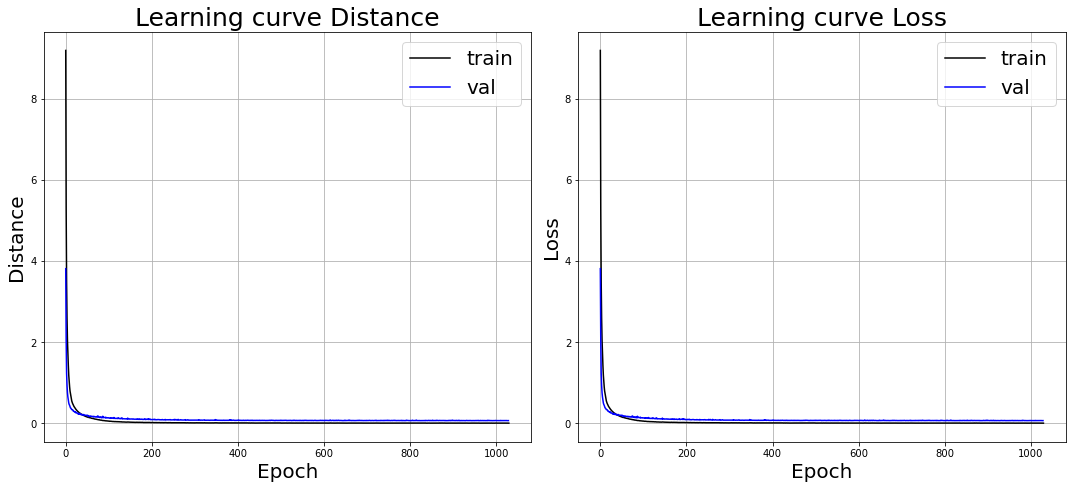

In [3]:
from utils.plots import plot_event

plot_event(args)

### Analyzing latent space.

In [4]:
# train, val, test
dataloader_train, _, dataloader = get_data(args)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
from utils.utils import pretrain_and_setC

model = build_network(args).to(args.device)
### Loading the trained model...
state_dict = torch.load('{}/trained_parameters.pth'.format(args.directory))
model.load_state_dict(state_dict)
model.eval()

###### IMPORTANTE #######
model.set_c(dataloader_train)

In [6]:
zs = []
scores = []
lbls_out = []
lbls_class = []
for _, x, lbl_class, lbl_out in dataloader:
    with torch.no_grad():
        x = x.float().to(args.device)

        z = model(x)
        zs.append(z.detach().cpu())
        score = model.compute_anomaly_score(x)
        scores.append(score.detach().cpu())
        lbls_out.append(lbl_out)
        lbls_class.append(lbl_class)
zs = torch.cat(zs).numpy()
scores = torch.cat(scores).numpy()
lbls_out = torch.cat(lbls_out).numpy()
lbls_class = torch.cat(lbls_class).numpy()

In [7]:
from sklearn.manifold import TSNE
import numpy as np 

x_embedded = TSNE(n_components=2).fit_transform(zs)

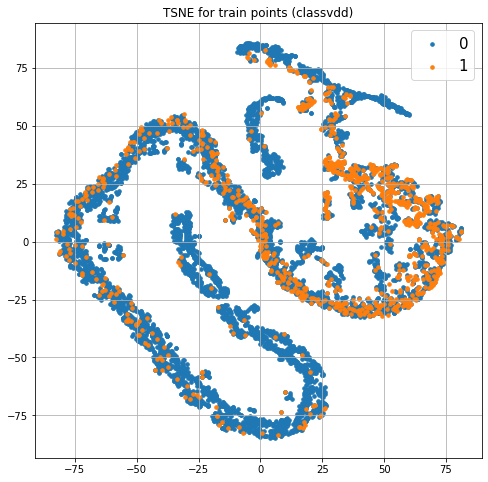

In [8]:
dict_classes = {0: 'Inlier',
                1: 'Outlier',
    
}

plt.figure(figsize=(8,8))
plt.title('TSNE for train points ({})'.format(args.model))
for key in range(len(np.unique(lbls_out))):
    plt.scatter(x_embedded[:, 0][lbls_out==key], x_embedded[:, 1][lbls_out==key], 
                s=50, alpha=1, marker='.', label=key)
plt.legend(fontsize=15)
plt.grid(True)

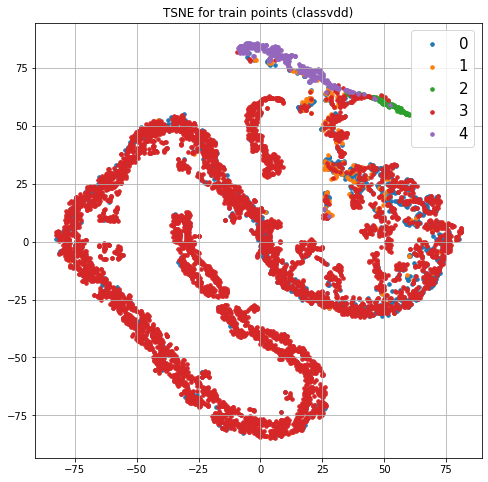

In [9]:
plt.figure(figsize=(8,8))
plt.title('TSNE for train points ({})'.format(args.model))
for key in range(len(np.unique(lbls_class))):
    plt.scatter(x_embedded[:, 0][lbls_class==key], x_embedded[:, 1][lbls_class==key], 
                s=50, alpha=1, marker='.', label=key)
plt.legend(fontsize=15)
plt.grid(True)

### Analizing scores

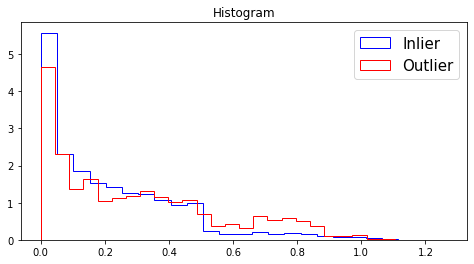

In [10]:
colors = {0: ('b', 'o'), #inlier
          1: ('red', '*'), #outlier
}

plt.figure(figsize=(8,4))
plt.title('Histogram')
for key in range(len(np.unique(lbls_out))):
    plt.hist(scores[lbls_out==key], label=dict_classes[key], bins=25, 
             density=True, histtype='step', color=colors[key][0])
plt.legend(fontsize=15)

### Report metrics

In [11]:
from sklearn.metrics import auc

def plot_metrics(args, metric_name, score, m1, m2):
    plt.title('{} curve. Score: {:.2f}'.format(metric_name, score), fontsize=20)
    plt.plot(m1, m2)
    if metric_name=='AU ROC':
        m1_name = 'FPR'
        m2_name = 'TPR'
        ident=[0.0, 1.0]
        plt.plot(ident, ident, c='r')
    elif metric_name=='AU PR':
        m1_name = 'Recall'
        m2_name = 'Precision'
        plt.plot([1.0, 0.0], [0.0, 1.0], c='r')
    plt.xlabel(m1_name, fontsize=18)
    plt.ylabel(m2_name, fontsize=18)
    plt.grid()
    plt.show()
    plt.close()
    
def compute_metrics(args, scores, labels):
    """
    Computing the Area under the curve ROC and PR.
    """
    in_scores = scores[labels==0]
    out_scores = scores[labels==1]

    auroc, aupr = compute_roc_pr(args, in_scores, out_scores)
    metrics = {'AU ROC': auroc,
               'AU PR': aupr,
               }
    return metrics

def compute_roc_pr(args, inliers_scores, outlier_scores):
    auroc_score, fprs, tprs = auroc(inliers_scores, outlier_scores)
    plot_metrics(args, 'AU ROC', auroc_score, fprs, tprs)
    aupr_score, recalls, precisions = aupr(inliers_scores, outlier_scores)
    plot_metrics(args, 'AU PR', aupr_score, recalls, precisions)
    return auroc_score, aupr_score

def auroc(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100000

    tprs = []
    fprs = []
    for delta in np.arange(end, start, -gap):
        tpr = np.sum(np.sum(out_scores >= delta)) / np.float(len(out_scores))
        fpr = np.sum(np.sum(in_scores >= delta)) / np.float(len(in_scores))
        tprs.append(tpr)
        fprs.append(fpr)
    return auc(fprs, tprs), fprs, tprs

def aupr(in_scores, out_scores):
    scores = np.concatenate((in_scores, out_scores), axis=0)
    start = np.min(scores)
    end = np.max(scores)   
    gap = (end - start)/100000
    
    precisions = []
    recalls = []
    for delta in np.arange(end, start, -gap):
        tp = np.sum(np.sum(out_scores >= delta)) #/ np.float(len(out_scores))
        fp = np.sum(np.sum(in_scores >= delta)) #/ np.float(len(in_scores))
        if tp + fp == 0: continue
        precision = tp / (tp + fp)
        recall = tp / np.float(len(out_scores))
        precisions.append(precision)
        recalls.append(recall)
    return auc(recalls, precisions), recalls, precisions

def print_metrics(metrics):
    for metric, value in metrics.items():
        print("{}: {:.3f}".format(metric, value))
    print("##########################################")

In [12]:
def test(args, dataloader, dataloader_train):
    """Evaluting the anomaly detection model."""
    model = build_network(args).to(args.device)
    ### Loading the trained model...
    state_dict = torch.load('{}/trained_parameters.pth'.format(args.directory))
    model.load_state_dict(state_dict)
    model.eval()
    
    ###### IMPORTANTE #######
    model.set_c(dataloader_train)
    
    scores = []
    out_labels = []
    
    model.eval()
    with torch.no_grad():
        for _, x, _, y_out in dataloader:
            x = x.float().to(args.device)

            score = model.compute_anomaly_score(x)
            scores.append(score.detach().cpu())
            out_labels.append(y_out.cpu())
    
    scores = torch.cat(scores).numpy()
    out_labels = torch.cat(out_labels).numpy()

    metrics = compute_metrics(args, scores, out_labels)
    print_metrics(metrics)

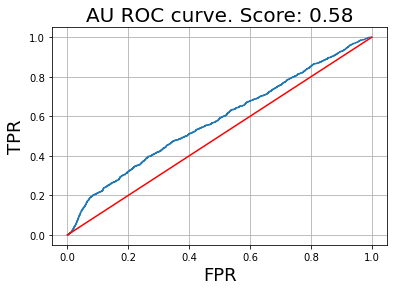

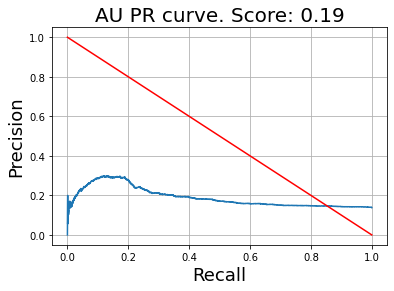

AU ROC: 0.579
AU PR: 0.188
##########################################


In [13]:
test(args, dataloader, dataloader_train)